# Машинное обучение, ФКН ВШЭ

## Практическое задание 3

### Общая информация
Дата выдачи: 27.11.2017  

Мягкий дедлайн: 23:59MSK 10.12.2017 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.12.2017  

### О задании

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI или из соревнования с платформы kaggle. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Почта: hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+151@gmail.com для студентов группы БПМИ-151)

Пришлите на почту архив homework-practice-03-Username.zip с выполненным заданием. Архив должен содержать:
* Ноутбук homework-practice-03-Username.ipynb
* Модуль hw3code.py

В контест https://contest.yandex.ru/contest/6469/problems/ нужно отправить файл hw3code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

* Ссылка на посылку в Яндекс.Контесте:
* Максимальная оценка: 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:
import numpy as np

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.95962796577701

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.61299968845643

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1. (0.3 балла)__
1. Сгенерируйте выборку $x$ из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных $y$ как сумму $f(x)$ и случайного шума, сгенерированного из равномерного распределения на отрезке $[-1, 1]$ (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: $f(x)$ и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [3]:
from sklearn.tree import DecisionTreeRegressor

def draw_trees_fx(samples_num, title, max_depth=None):
    X = np.random.exponential(size=(samples_num, sample_size))
    y = f(X) + np.random.uniform(-1, 1, (samples_num, sample_size))

    trees = [DecisionTreeRegressor(max_depth=max_depth).fit(X[i][:,np.newaxis], y[i])
             for i in range(samples_num)]
    y_preds = np.array([tree.predict(linspace[:,np.newaxis]) for tree in trees])

    plt.figure(figsize=(15, 5))
    plt.plot(linspace, y_preds[0], label=r'$\hat f(x)$', color='gray', alpha=0.3)
    for y_pred in y_preds[1:]:
        plt.plot(linspace, y_pred, color='gray', alpha=0.3)
    plt.plot(linspace, y_preds.mean(axis=0), color='black', label=r'$\hat f_k(x)$')
    plt.plot(linspace, f(linspace), label='$f(x)$', color='red')
    plt.grid()
    plt.xlabel('x', size=15)
    plt.ylabel('$f(x)$', size=15)
    plt.title(title, size=20)
    plt.legend()
    plt.show()

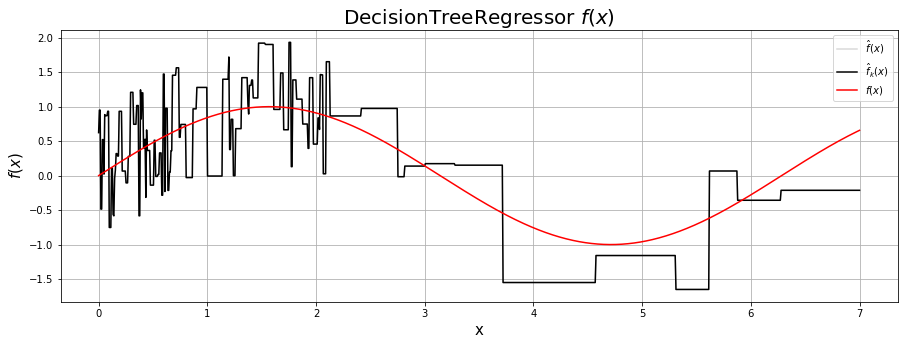

In [7]:
draw_trees_fx(1, 'DecisionTreeRegressor $f(x)$')

__2. (0.3 балла)__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

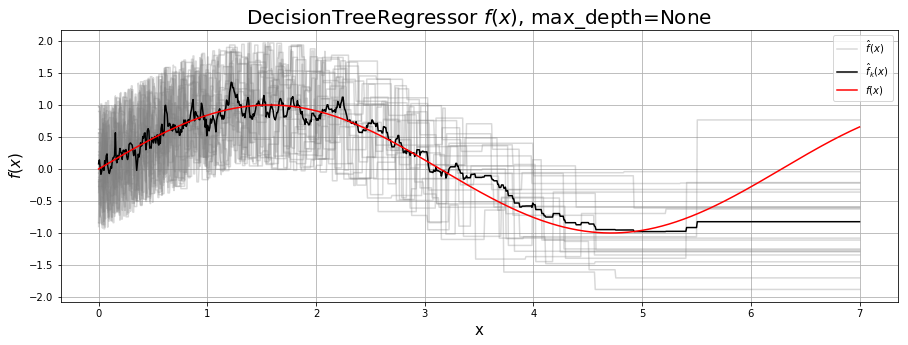

In [8]:
draw_trees_fx(samples_num, 'DecisionTreeRegressor $f(x)$, max_depth=None')

__3. (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика. __Избегайте копипасты кода! Сделайте функцию, параметризованную максимальной глубиной дерева, которая отрисовывает необходимые картинки!__

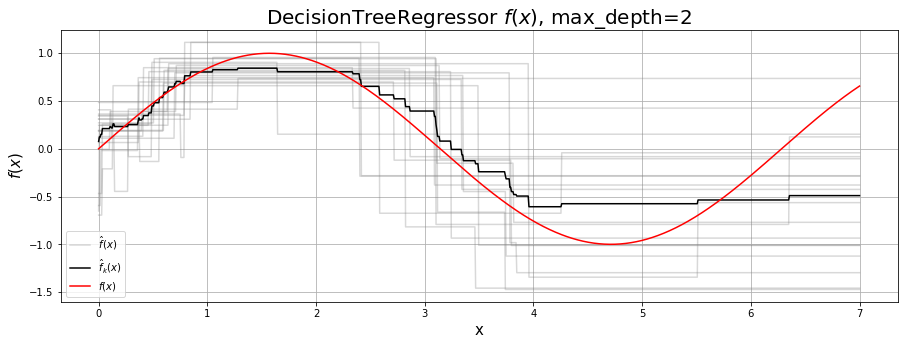

In [9]:
draw_trees_fx(samples_num, 'DecisionTreeRegressor $f(x)$, max_depth=2', 2)

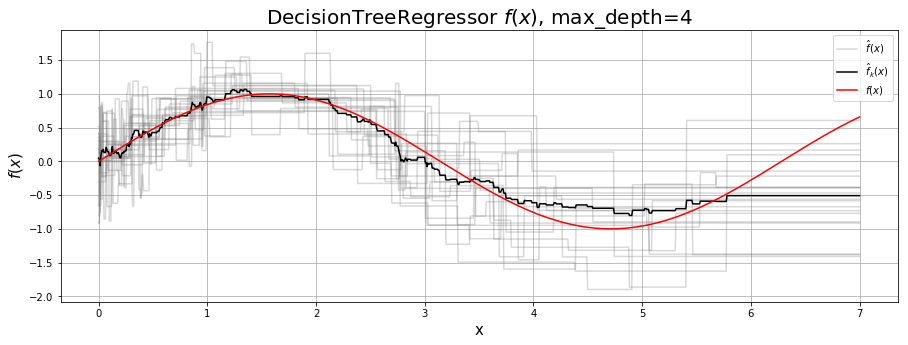

In [10]:
draw_trees_fx(samples_num, 'DecisionTreeRegressor $f(x)$, max_depth=4', 4)

__4. (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

**Ответ:** Судя по полученным графикам, смещение убывает при возрастании максимальной глубины решающего дерева, что согласуется с теорией. Смещение довольно близко к нулю на дереве без ограничения глубины (где-то при $x > 5.5$ среднее предсказание начинает отклоняться от реальной функции, но т.к. у нас экспоненциальное распределени, то мера полуинтервала $[5.5, +\infty]$ довольно мала.

#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте — это сумма истинного значения функции на объекте + шумовая компонента, также сгенерированная из некоторого распределения.

__5. (1 балл) __ 

Реализуйте функцию compute_bias_variance из модуля hw3code.py

__6. (0.4 балла)__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [83]:
regressors = [LinearRegression(), 
              DecisionTreeRegressor(), 
              RandomForestRegressor(),
              GradientBoostingRegressor()]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              lambda size: np.random.uniform(0, 1, size=size)]

In [84]:
df_bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                       index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
df_variance = pd.DataFrame(columns=df_bias.columns, index=df_bias.index)

In [92]:
from importlib import reload
import hw3code

reload(hw3code)

<module 'hw3code' from '/home/randan/hse/ml1/homework_practice_03/hw3code.py'>

In [93]:
for regressor, index in zip(regressors, df_bias.index):
    for generator, column in zip(generators, df_bias.columns):
        bias, variance = hw3code.compute_bias_variance(regressor, lambda x: 5 * np.sin(10 * x),
                                                       generator)
        df_bias.loc[index, column] = bias
        df_variance.loc[index, column] = variance

In [94]:
df_bias

normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression        12.2918          8.49524        10.3229       11.7685
DecisionTree           0.110741         0.239285       0.107711     0.0886397
RandomForest          0.0674864         0.155885      0.0767189     0.0485731
GradientBoosting      0.0652599         0.179355      0.0733241     0.0428939

In [95]:
df_variance

normal(0, 0.3) exponential(0.3) uniform(-1, 1) uniform(0, 1)
LinearRegression      0.0147497          1.44686       0.633955      0.171326
DecisionTree            12.4474          9.75878        10.9712       11.8984
RandomForest            12.2574          9.46277        10.9066       11.8165
GradientBoosting        12.2024          9.53169        10.6881       11.7465

__7. (0.6 балла)__

Проанализируйте полученные таблицы. Ответьте на вопросы:
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

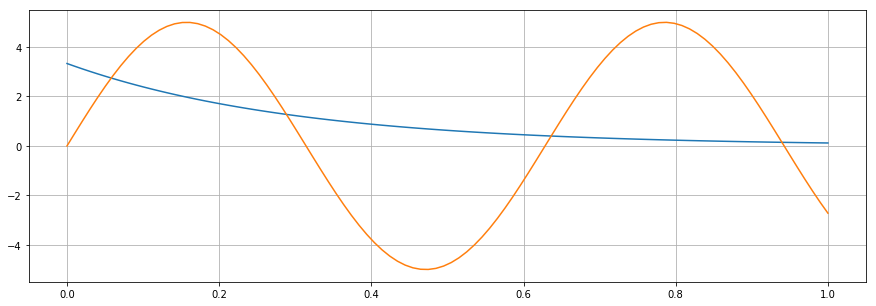

In [109]:
import scipy.stats as sps
grid = np.linspace(0, 1, 100)
plt.figure(figsize=(15, 5))
plt.plot(grid, sps.expon(scale=0.3).pdf(grid))
plt.grid()
plt.plot(grid, 5 * np.sin(10 * grid))
plt.show()

**Ответ:** 
* Наименьший разброс оказался у линейной регрессии (при наибольшем смещении). Разбросы DecisionTree, RandomForest и GradientBoosting в целом, похожи. Согласно теории, DecisionTree без ограничения глубины имеет большой разброс, при этом RandomForest призван этот разброс уменьшить, что и произошло. У градиентного бустинга разброс в среднем ещё меньше, чем у RandomForest.
* Судя по полученным таблицам, смещение и разброс алгоритма всё таки зависят от вероятностной модели данных. Что вообщем-то согласуется с определениями.
* Смещение решающих деревьев велико при экспоненциальном распределении. 

__8. (бонус, 0.5 балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [18]:
def draw_bias_variance(param_name, params, regressors):   
    bias_fig, bias_axarr = plt.subplots(2, 2, True, True, figsize=(15, 15))
    variance_fig, variance_axarr = plt.subplots(2, 2, True, True, figsize=(15, 15))
    
    bias_fig.suptitle('Bias({})'.format(param_name), size=20)
    variance_fig.suptitle('Variance({})'.format(param_name), size=20)
    
    for generator, column, bias_ax, variance_ax in zip(generators, df_bias.columns,
                                                       bias_axarr.flat,
                                                       variance_axarr.flat):
        bias_ax.set_title(column, size=15)
        variance_ax.set_title(column, size=15)
        bias_ax.set_xlabel(param_name, size=10)
        variance_ax.set_xlabel(param_name, size=10)
        bias_ax.set_ylabel('bias', size=10)
        variance_ax.set_ylabel('variance', size=10)
        
        for regressor, index in zip(regressors, df_bias.index):
            bias = []
            variance = []
            
            for param in params:
                b, v = hw3code.compute_bias_variance(regressor, lambda x: 5 * np.sin(10 * x),
                                                     generator, **{param_name:param})
                bias.append(b)
                variance.append(v)
                
            bias_ax.plot(params, bias, label=index)
            variance_ax.plot(params, variance, label=index)
            
        bias_ax.legend()
        variance_ax.legend()

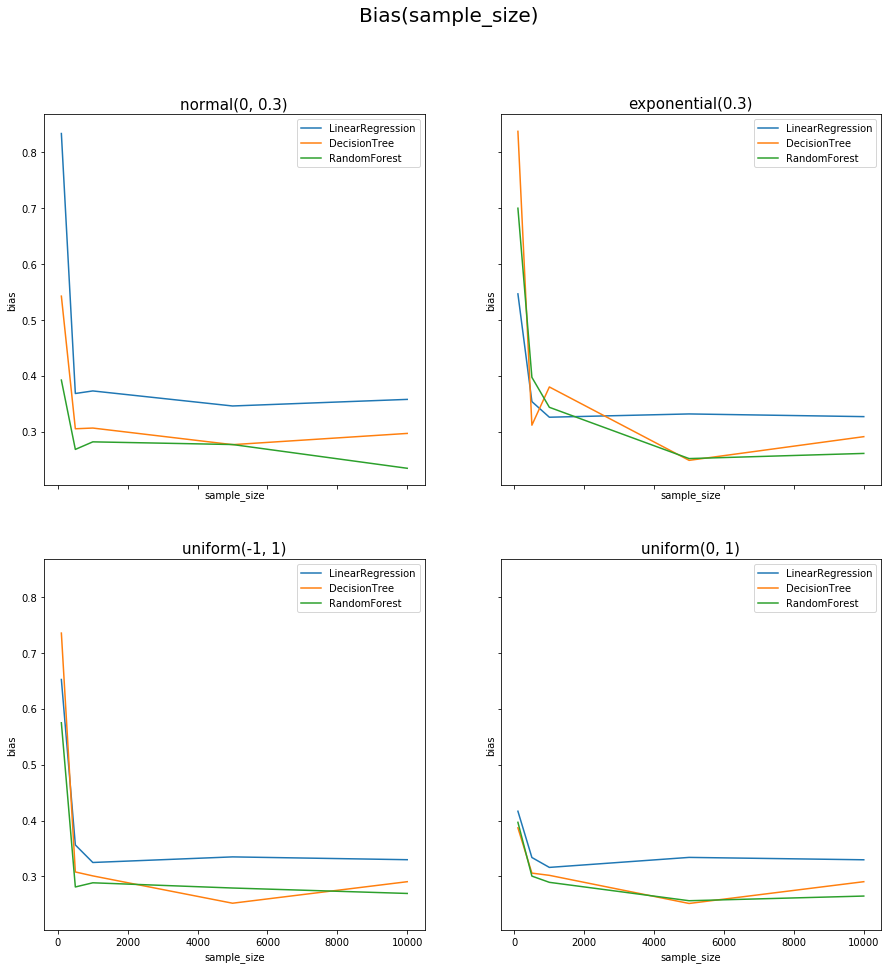

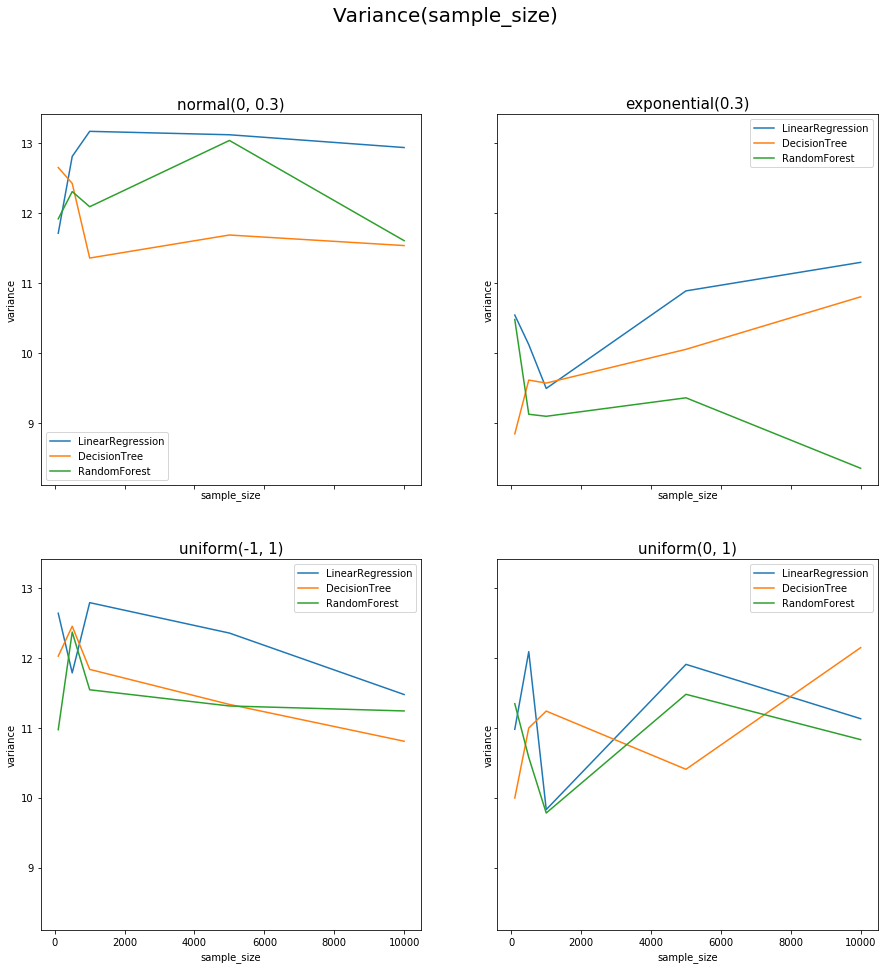

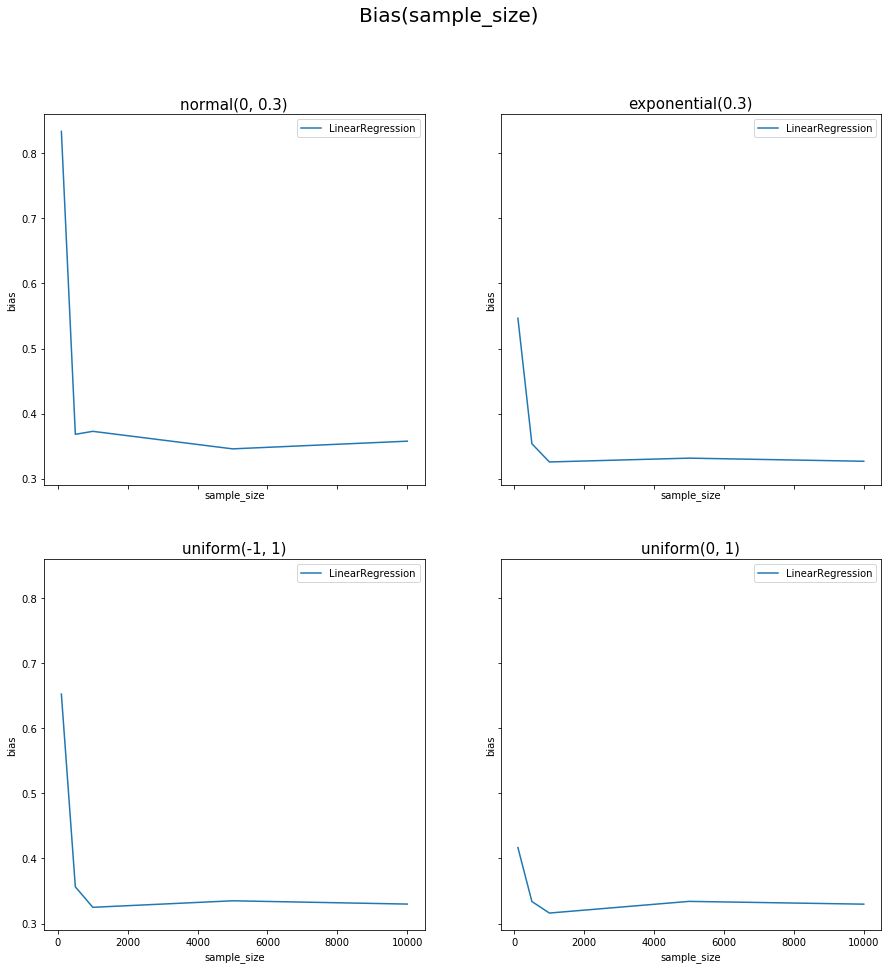

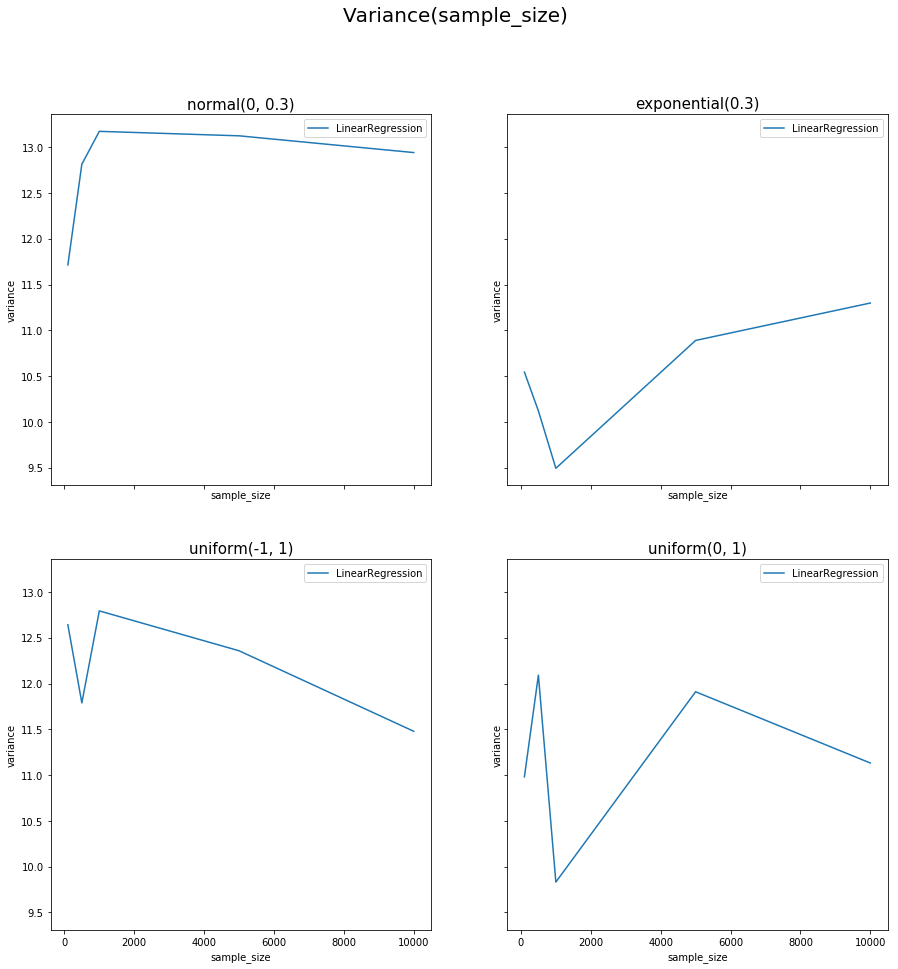

In [19]:
draw_bias_variance('sample_size', [100, 500, 1000, 5000, 10000], regressors[1:])
draw_bias_variance('sample_size', [100, 500, 1000, 5000, 10000], [regressors[1]])

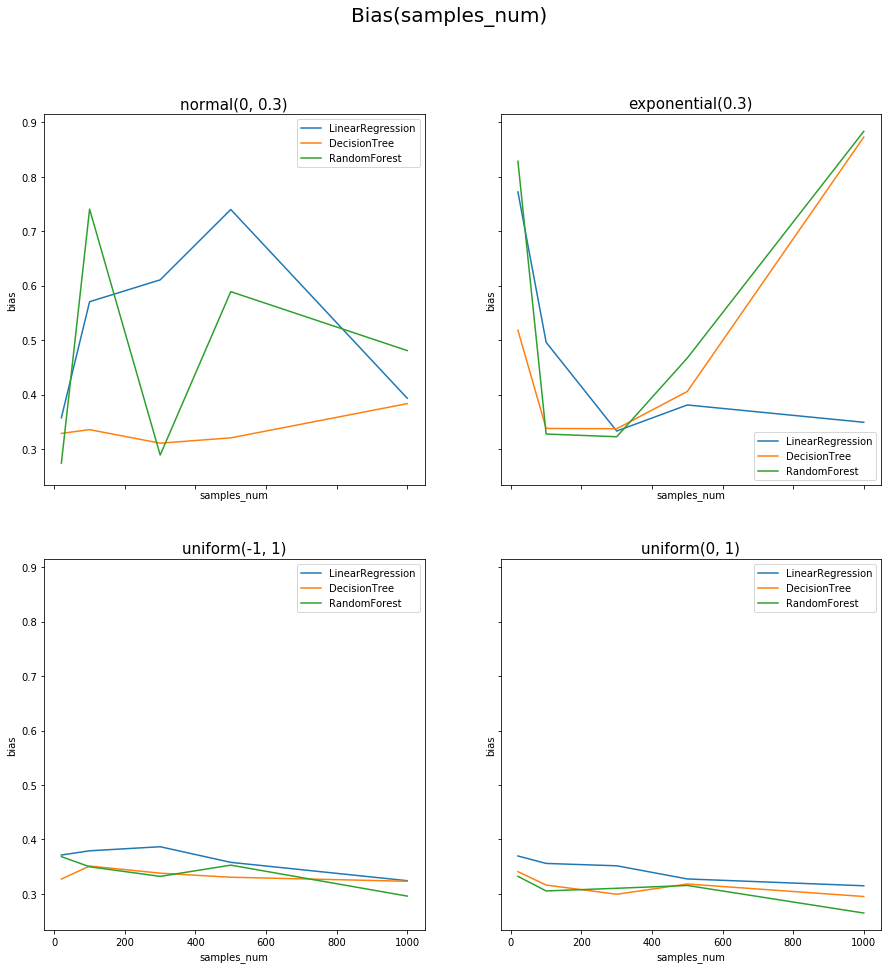

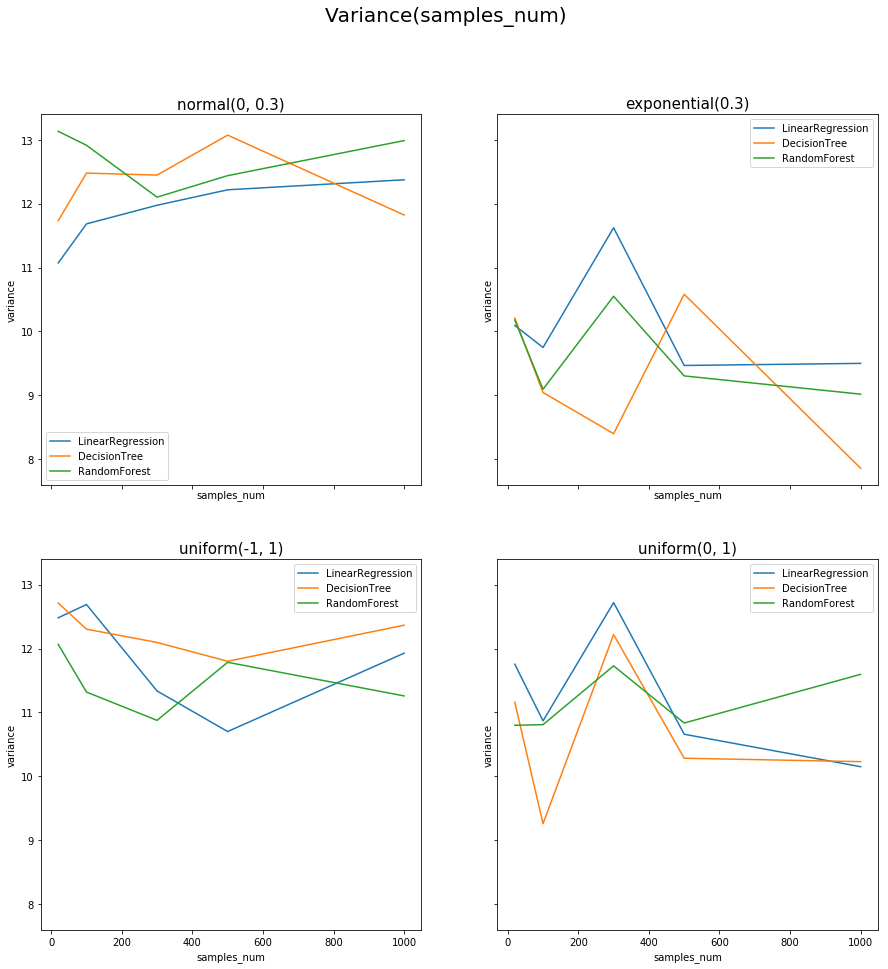

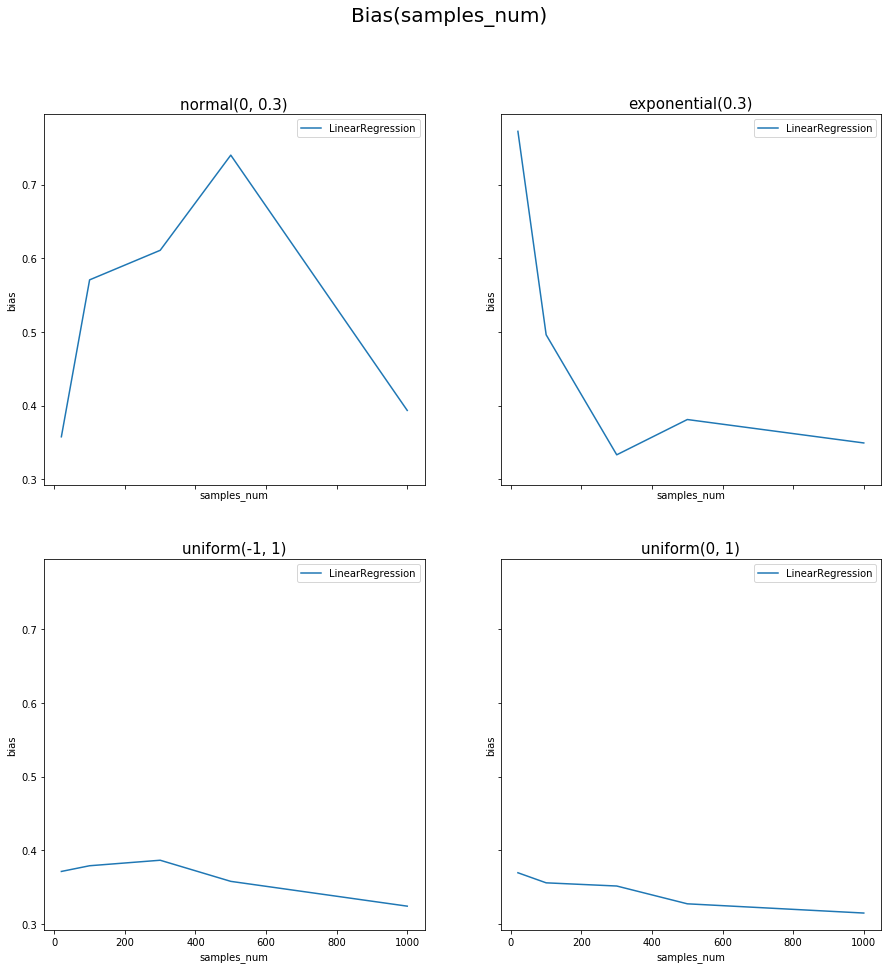

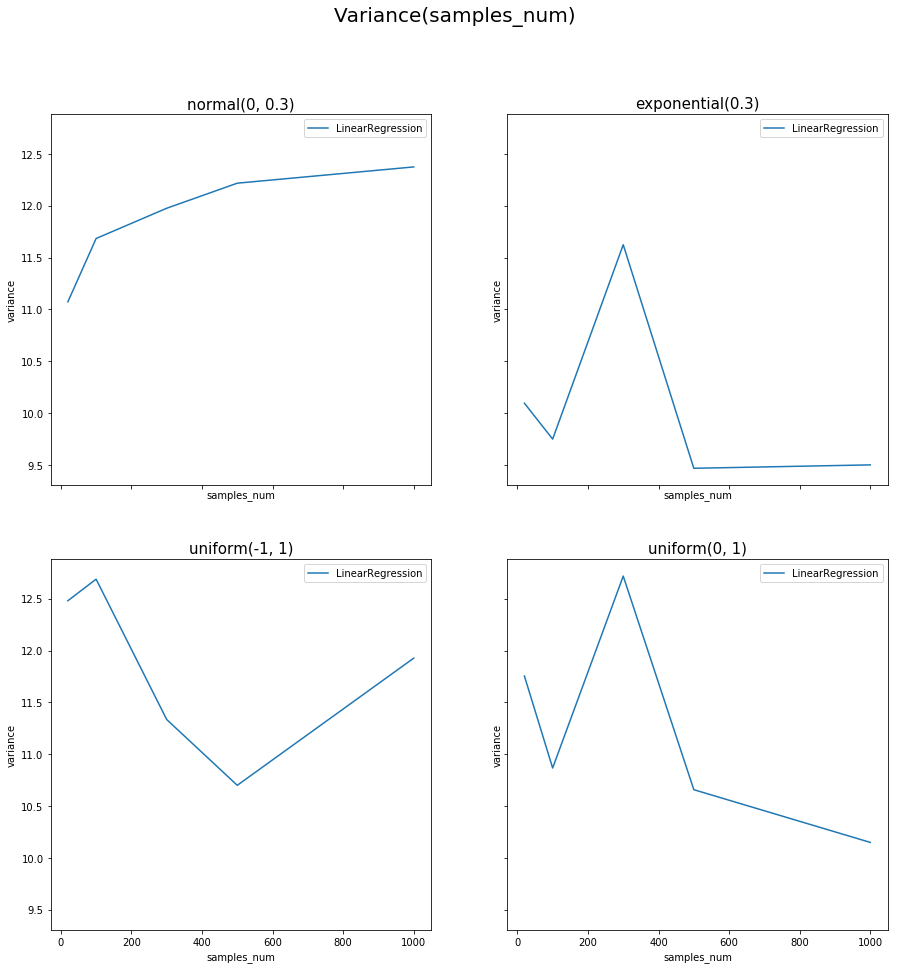

In [20]:
draw_bias_variance('samples_num', [20, 100, 300, 500, 1000], regressors[1:])
draw_bias_variance('samples_num', [20, 100, 300, 500, 1000], [regressors[1]])

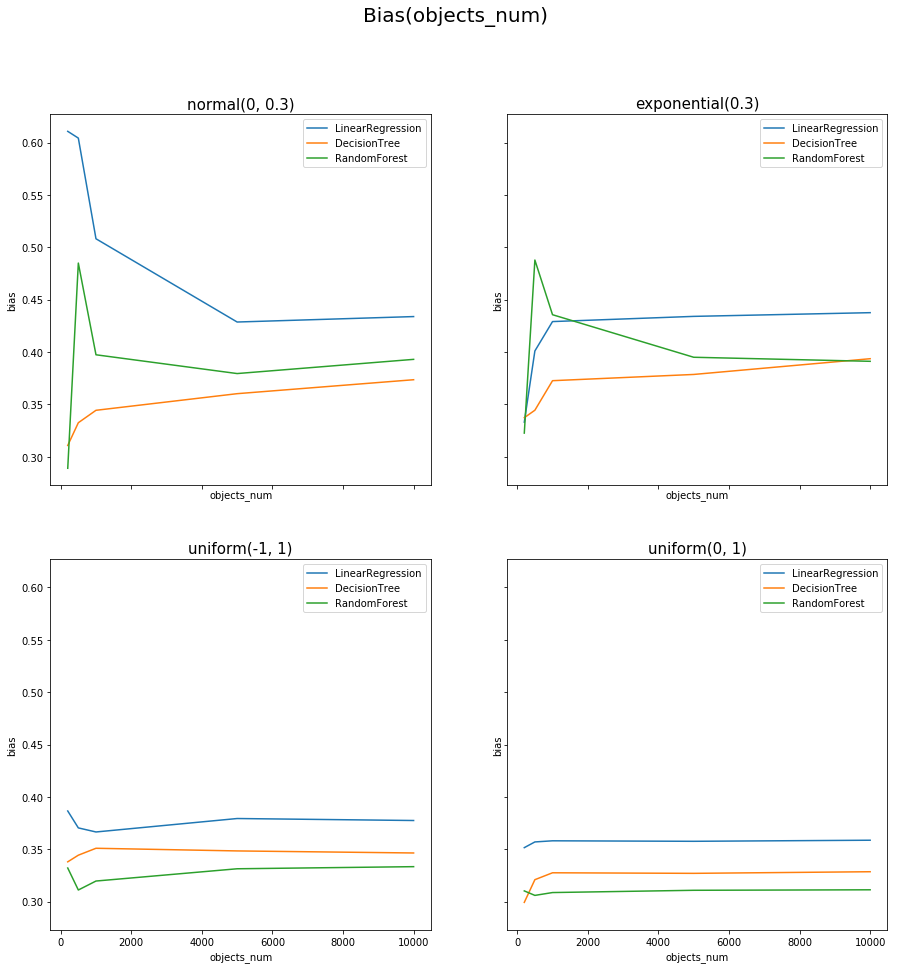

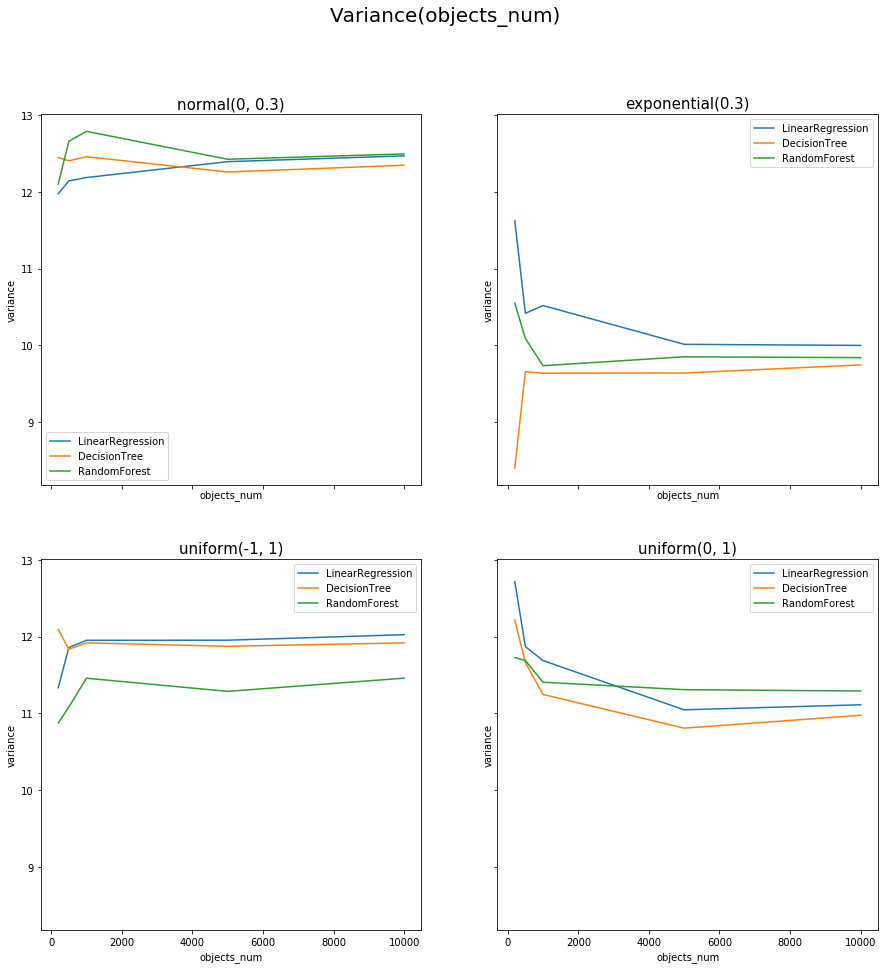

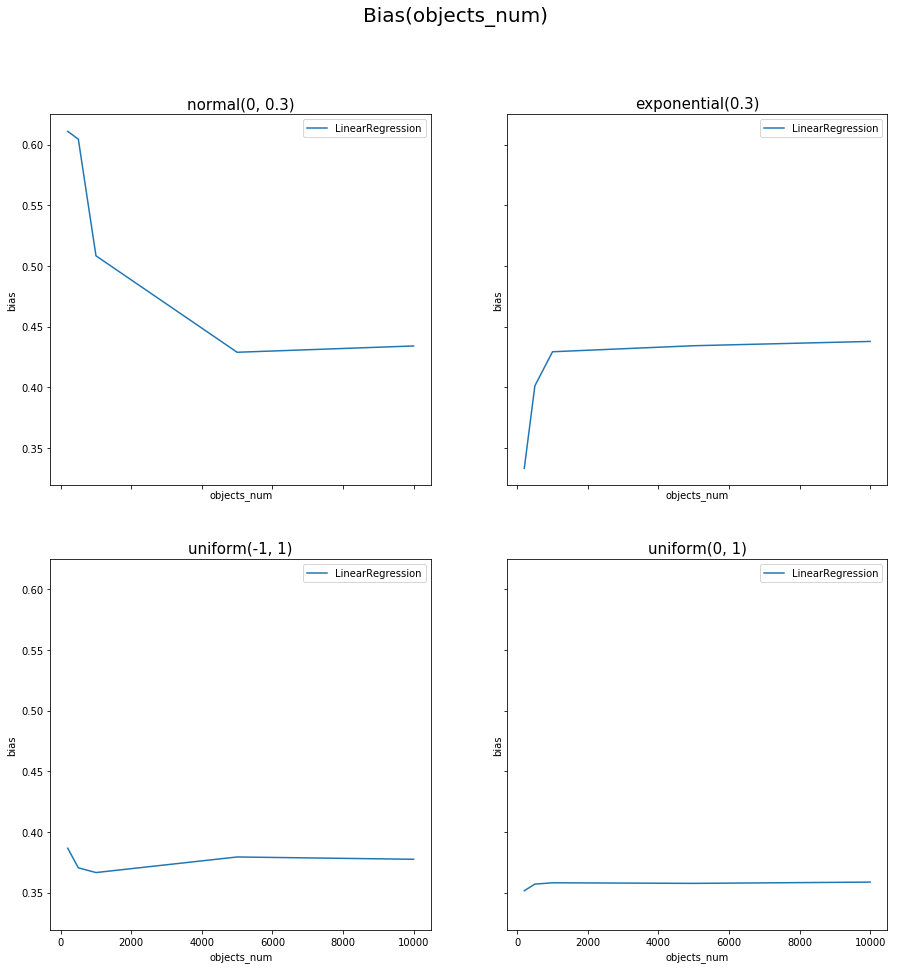

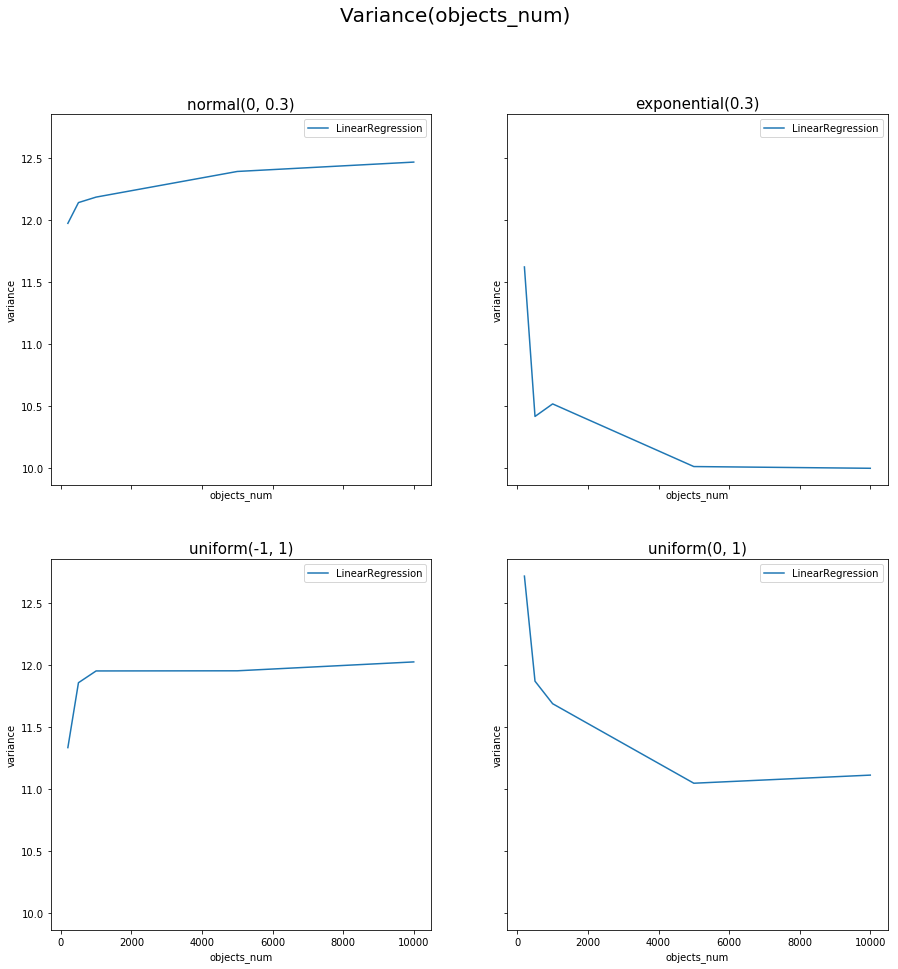

In [21]:
draw_bias_variance('objects_num', [200, 500, 1000, 5000, 10000], regressors[1:])
draw_bias_variance('objects_num', [200, 500, 1000, 5000, 10000], [regressors[1]])

**Вывод:** Судя по полученным графикам, параметры samples_num и objects_num не влияют на смещение или разброс, но влияют на точность их вычисления, что полностью согласуется с теорией. Графики по sample_size довольно шумные, однако на некоторых графиках прослеживается изменение разброса, что тоже согласуется с теорией.

### II. Решающие деревья своими руками

#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__9. (0.5 балла)__

Реализуйте функцию find_best_split из модуля hw3code.py

In [82]:
reload(hw3code)

<module 'hw3code' from '/home/randan/hse/ml1/homework_practice_03/hw3code.py'>

__10. (0.5 балла)__

Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [23]:
students = pd.read_csv('students.csv')
students.head()

STG   SCG   STR   LPR   PEG   UNS
0  0.00  0.00  0.00  0.00  0.00     0
1  0.08  0.08  0.10  0.24  0.90     1
2  0.06  0.06  0.05  0.25  0.33     0
3  0.10  0.10  0.15  0.65  0.30     1
4  0.08  0.08  0.08  0.98  0.24     0

Похоже, что в первой строке какие-то неправильные данные, дропнем их.

In [24]:
students.drop(index=0, inplace=True)

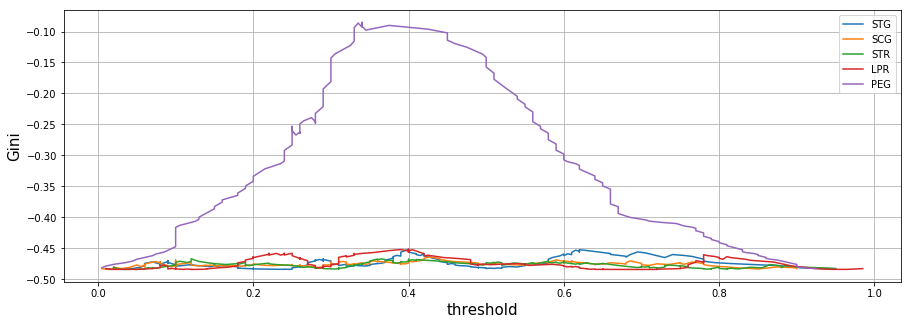

In [25]:
plt.figure(figsize=(15, 5))
plt.xlabel('threshold', size=15)
plt.ylabel('Gini', size=15)
plt.grid()

for feature in students.drop(' UNS', axis=1).columns:
    thresholds, ginis, _, _ =\
        hw3code.find_best_split(students[feature].as_matrix(), students[' UNS'].as_matrix())
    plt.plot(thresholds, ginis, label=feature)
    
plt.legend()
plt.show()

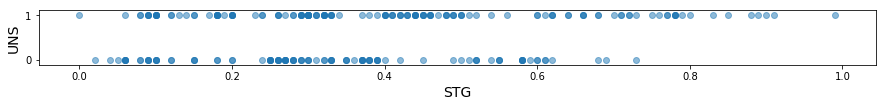

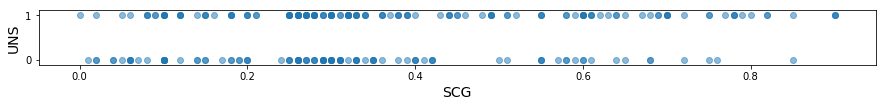

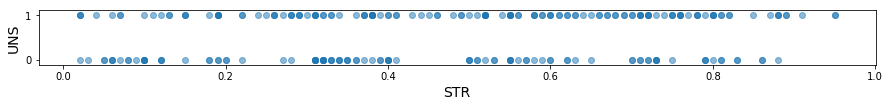

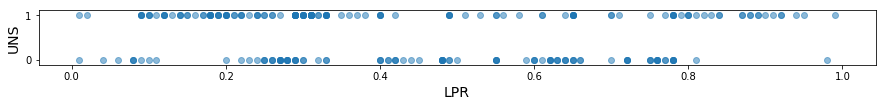

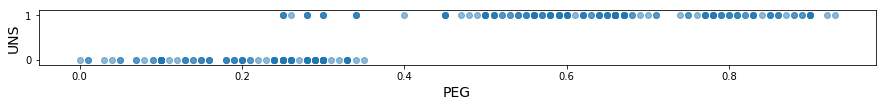

In [26]:
for feature in students.drop(' UNS', axis=1).columns:
    plt.figure(figsize=(15, 1))
    plt.xlabel(feature, size=14)
    plt.ylabel('UNS', size=14)
    plt.scatter(students[feature], students[' UNS'], alpha=0.5)
    plt.show()

__11. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Видно, что наилучшее значение функционала достигается при делении по признаку PEG. Это связано с тем, что по данному признаку можно разбить выборку так, чтобы в каждой части подвыборка состояла практически из одного класса. Это согласуется с теорией, т.к. критерий информативности Джини принимает минимальные значения на вырожденных классах. Все остальные признаки невозможно разделить подобным образом.

__12. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw3code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

In [141]:
reload(hw3code)

<module 'hw3code' from '/home/randan/hse/ml1/homework_practice_03/hw3code.py'>

__13. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [166]:
mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data',
                        header=None)
mushrooms.head()

0  1  2  3  4  5  6  7  8  9  ... 13 14 15 16 17 18 19 20 21 22
0  p  x  s  n  t  p  f  c  n  k ...  s  w  w  p  w  o  p  k  s  u
1  e  x  s  y  t  a  f  c  b  k ...  s  w  w  p  w  o  p  n  n  g
2  e  b  s  w  t  l  f  c  b  n ...  s  w  w  p  w  o  p  n  n  m
3  p  x  y  w  t  p  f  c  n  n ...  s  w  w  p  w  o  p  k  s  u
4  e  x  s  g  f  n  f  w  b  k ...  s  w  w  p  w  o  e  n  a  g

[5 rows x 23 columns]

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [167]:
labeled_mushrooms = np.apply_along_axis(LabelEncoder().fit_transform, 0, mushrooms.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(labeled_mushrooms[:,1:],
                                                    labeled_mushrooms[:,0], test_size=0.5)

In [168]:
decision_tree = hw3code.DecisionTree(np.array(['categorical' for x in range(X_train.shape[1])]))
decision_tree.fit(X_train, y_train)

In [169]:
print('accuracy:', accuracy_score(y_test, decision_tree.predict(X_test)))
print('depth:', decision_tree._depth)

accuracy: 1.0
depth: 6


__14. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [170]:
tic_tac_toe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                          header=None)
tic_tac_toe.head()

0  1  2  3  4  5  6  7  8         9
0  x  x  x  x  o  o  x  o  o  positive
1  x  x  x  x  o  o  o  x  o  positive
2  x  x  x  x  o  o  o  o  x  positive
3  x  x  x  x  o  o  o  b  b  positive
4  x  x  x  x  o  o  b  o  b  positive

In [171]:
labeled_tic_tac_toe = np.apply_along_axis(LabelEncoder().fit_transform, 0, tic_tac_toe.as_matrix())
X_train, X_test, y_train, y_test = train_test_split(labeled_tic_tac_toe[:,:-1],
                                                    labeled_tic_tac_toe[:,-1], test_size=0.5)

In [172]:
def draw_param_test(param_name, params):   
    plt.figure(figsize=(15, 5))
    plt.xlabel(param_name, size=15)
    plt.ylabel('accuracy', size=15)
    plt.grid()
    
    train_accuracy = []
    test_accuracy = []
    for param in params:
        decision_tree = hw3code.DecisionTree(np.array(['categorical' for x in range(X_train.shape[1])]),
                                             **{param_name:param})
        decision_tree.fit(X_train, y_train)
        train_accuracy.append(accuracy_score(y_train, decision_tree.predict(X_train)))
        test_accuracy.append(accuracy_score(y_test, decision_tree.predict(X_test)))
    
    plt.plot(params, train_accuracy, label='train')
    plt.plot(params, test_accuracy, label='test')
    plt.legend()
    plt.show()

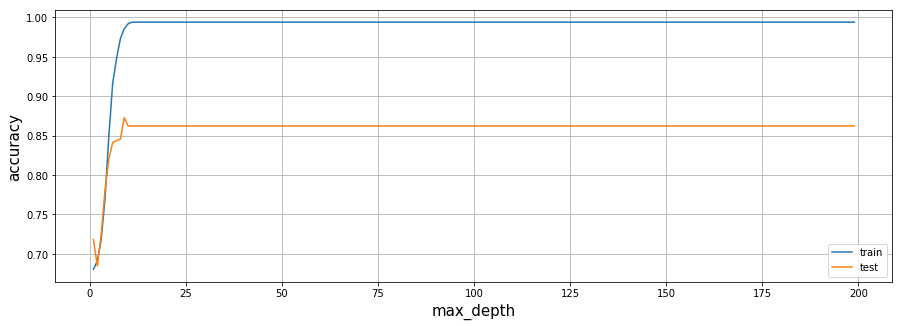

In [173]:
max_depths = np.arange(1, 200)
draw_param_test('max_depth', max_depths)

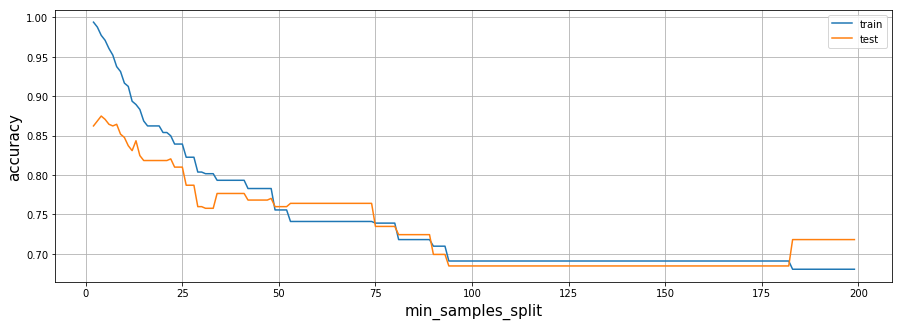

In [174]:
min_samples_split = np.arange(2, 200)
draw_param_test('min_samples_split', min_samples_split)

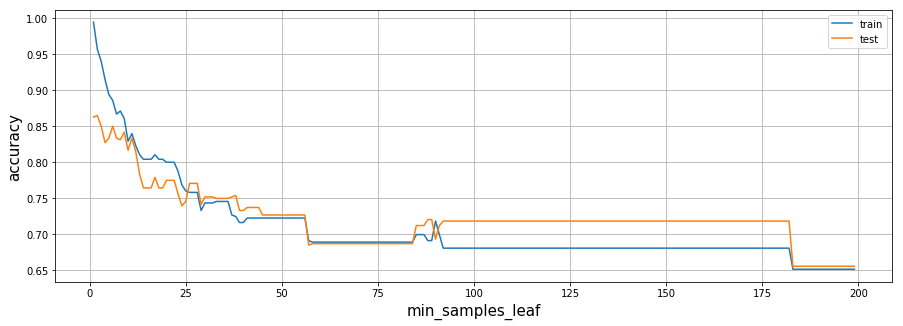

In [175]:
min_samples_leaf = np.arange(1, 200)
draw_param_test('min_samples_leaf', min_samples_leaf)

**Вывод:** с ростом максимальной глубины точность увеличивается, пока не достигнет ассимптоты, что связано с возможной неразделимостью некоторых объектов. С увеличением минимального числа объектов для сплита и минимального числа объектов в листе точность падает, для тренировочной выборки это вполне понятный результат. Судя по всему на предложенном датасете дерево не переобучается, т.к. для тестовой выборки наблюдается тот же результат.

__15. (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [176]:
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

In [177]:
cars.loc[:,6].replace({'unacc':0, 'acc':0, 'good':1, 'vgood':1}, inplace=True)
nursery.loc[:,8].replace({'not_recom':0, 'recommend':0, 'very_recom':1, 'priority':1, 'spec_prior':1}, inplace=True)

In [178]:
labeled_cars = np.apply_along_axis(LabelEncoder().fit_transform, 0, cars.as_matrix())
labeled_nursery = np.apply_along_axis(LabelEncoder().fit_transform, 0, nursery.as_matrix())

In [179]:
reload(hw3code)

<module 'hw3code' from '/home/randan/hse/ml1/homework_practice_03/hw3code.py'>

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [180]:
alg_data = pd.DataFrame(index=['All real', 'All categorical', 'All real + OneHot', 'DecisionTreeClassifier'],
                        columns=['mushrooms', 'tic-tac-toe', 'cars', 'nursery'])


tree_one_hot = Pipeline([('OneHot', OneHotEncoder(sparse=False)),
                         ('DecisionTree', hw3code.DecisionTree('real'))])

algs = [hw3code.DecisionTree('real'),
        hw3code.DecisionTree('categorical'),
        tree_one_hot,
        DecisionTreeClassifier()]

Xs = [labeled_mushrooms[:,1:], labeled_tic_tac_toe[:,:-1], labeled_cars[:,:-1], labeled_nursery[:,:-1]]
ys = [labeled_mushrooms[:,0], labeled_tic_tac_toe[:,-1], labeled_cars[:,-1], labeled_nursery[:,-1]]

In [182]:
for index, alg in zip(alg_data.index, algs):
    for X, y, column in zip(Xs, ys, alg_data.columns):
        alg_data.loc[index, column] = cross_val_score(alg, X, y, scoring='accuracy', cv=10, n_jobs=4).mean()
alg_data

mushrooms tic-tac-toe      cars   nursery
All real                0.999261    0.658618  0.906688  0.999846
All categorical                1    0.568849  0.961181  0.999846
All real + OneHot              1    0.737807  0.917126  0.999846
DecisionTreeClassifier  0.958154    0.758312  0.940972  0.999691

__16. (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

In [191]:
cars.head()

0      1  2  3      4     5  6
0  vhigh  vhigh  2  2  small   low  0
1  vhigh  vhigh  2  2  small   med  0
2  vhigh  vhigh  2  2  small  high  0
3  vhigh  vhigh  2  2    med   low  0
4  vhigh  vhigh  2  2    med   med  0

**Ответ:** на датасетах mushrooms и nursery какой-то существенной разницы не наблюдается (хотя DecisionTreeClassifier на mushrooms сработал хуже, чем остальные алгоритмы), возможно, это связано с тем, что нам повезло при кодировании категориальных признаков вещественными метками.
На датасете tic-tac-toe категориальные признаки оказались хуже действительныйх, сложно сказать с чем это связано, возможно, со случайностью кодирования или с тем, в нашей реализации DecisionTree значениям признака, которые отсутствовали в подвыборке при построении предиката присваиваются минимальные значения.
OneHot на датасете tic-tac-toe показал себя лучше, чем "категориальный" способ, но хуже на датасете cars. Вообще OneHot сильно увеличивает количество признаков, тем самым усложняя структуру дерева, что может вести к переобучению.
DecisionTreeClassifier везде показывает довольно хорошие результаты, возможно, в нём каким-то другим образом ищется разбиение в вершинах.

Элемент случайности, связанный со значениями признаков, присутствует, если мы считаем все признаки действительными, но не используем OneHot, т.к. в таком случае LabelEncoder задаёт случайный порядок на признаках. Было бы логично убрать случайность, применяя тот же трюк, что и для работы с категориальными признаками в DecisionTree, тогда порядок на признаках будет обоснован. После этого алгоритм в среднем должен работать лучше.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__17. (0.5 балла)__

Загрузите датасет из соревнования [BNP Paribas Cardif Claims Management](https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/leaderboard). Возьмите из него первые 10к объектов, оставьте только вещественные признаки, а пропуски замените нулями. Разбейте выборку на обучение и контроль в соотношении 7:3.

1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов на обучающей выборке:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом (если это не так, то посмотрите как ведут себя алгоритмы с разными сидами в кроссвалидации и самих алгоритмах). Этот пример демонстрирует, что RandomForest — это более сложный алгоритм, чем бэггинг. 

In [8]:
data = pd.read_csv('train.csv')[:10000]
data.fillna(0, inplace=True)
data.drop('ID', axis=1, inplace=True)
data.head()

target        v1        v2 v3        v4         v5        v6        v7  \
0       1  1.335739  8.727474  C  3.921026   7.915266  2.599278  3.176895   
1       1  0.000000  0.000000  C  0.000000   9.191265  0.000000  0.000000   
2       1  0.943877  5.310079  C  4.410969   5.326159  3.979592  3.928571   
3       1  0.797415  8.304757  C  4.225930  11.627438  2.097700  1.987549   
4       1  0.000000  0.000000  C  0.000000   0.000000  0.000000  0.000000   

         v8         v9    ...         v122      v123      v124  v125  \
0  0.012941   9.999999    ...     8.000000  1.989780  0.035754    AU   
1  2.301630   0.000000    ...     0.000000  0.000000  0.598896    AF   
2  0.019645  12.666667    ...     9.333333  2.477596  0.013452    AE   
3  0.171947   8.965516    ...     7.018256  1.812795  0.002267    CJ   
4  0.000000   0.000000    ...     0.000000  0.000000  0.000000     Z   

       v126      v127      v128  v129      v130      v131  
0  1.804126  3.113719  2.024285     0  0.636365  2.857144  
1  0.000000  0.000000  1.957825     0  0.000000  0.000000  
2  1.773709  3.922193  1.120468     2  0.883118  1.176472  
3  1.415230  2.954381  1.990847     1  1.677108  1.034483  
4  0.000000  0.000000  0.000000     0  0.000000  0.000000  

[5 rows x 132 columns]

Будем считать, что ID вообще не признак и просто дропнем его (уже дропнут выше). Также будем считать, что признаки с dtype=int и dtype=object — категориальные, а с dtype=float — вещественные (других нет).

In [9]:
reals = [column[1].dtype == float for column in data.iteritems()]

X_train, X_test, y_train, y_test = train_test_split(data.loc[:,reals], data['target'], test_size=0.3,
                                                    random_state=1488)

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [227]:
names = ['DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier']
for estimator, name in zip([DecisionTreeClassifier(),
                            BaggingClassifier(n_estimators=100),
                            RandomForestClassifier(n_estimators=100)], names):
    print(name, 'accuracy:', cross_val_score(estimator, X_train, y_train, scoring='accuracy', n_jobs=4).mean())

DecisionTreeClassifier accuracy: 0.657715210387
BaggingClassifier accuracy: 0.741713744637
RandomForestClassifier accuracy: 0.747142112235


#### Задача 5. Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__18. (0.5 балла)__

Переберите значения от 20 до 1000-5000 деревьев с шагом 20, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $20 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

100%|██████████| 250/250 [04:07<00:00,  1.01it/s]


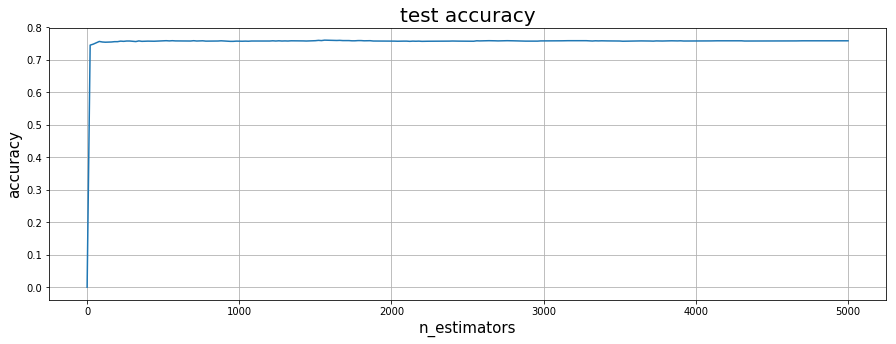

In [248]:
test_accuracys = [0]
random_forest = RandomForestClassifier(n_estimators=20, warm_start=True, n_jobs=4)
grid = range(20, 5020, 20)

for n_estimators in tqdm(grid):
    random_forest.set_params(n_estimators = n_estimators)
    random_forest.fit(X_train, y_train)
    test_accuracys.append(random_forest.score(X_test, y_test))

plt.figure(figsize=(15, 5))
plt.title('test accuracy', size=20)
plt.xlabel('n_estimators', size=15)
plt.ylabel('accuracy', size=15)
plt.grid()
plt.plot([0] + list(grid), test_accuracys)
plt.legend()
plt.show()

Как видно, переобучения не происходит.

#### Задача 6. Обучение градиентного бустинга

__19. (1 балл)__

А теперь попробуйте обучить на тех же данных xgboost — одну из реализаций градиентного бустинга. Подберите параметры на обучающем множестве с помощью кроссвалидации (хорошая [статья](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) про тюнинг параметров xgboost). 

In [11]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [12]:
dtrain = xgb.DMatrix(X_train, y_train)

In [153]:
def fit_model(alg, cv=5, early_stopping_rounds=50):
    xgb_param = alg.get_xgb_params()
    n_est = alg.get_params()['n_estimators']
        
    cv_res = xgb.cv(xgb_param, dtrain, num_boost_round=n_est,
                    nfold=cv, metrics='auc', early_stopping_rounds=early_stopping_rounds)
    
    alg.set_params(n_estimators=cv_res.shape[0])
    
    alg.fit(X_train, y_train, eval_metric='auc')
    print('best CV res:', cv_res['test-auc-mean'].max())
    print('n_estimators:', cv_res.shape[0])
    print('AUC train:', alg.score(X_train, y_train))
    print('AUC test:', alg.score(X_test, y_test))
    return cv_res.shape[0]

In [14]:
param = {'objective':'binary:logistic', 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8,
         'n_estimators':1000}

param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.703361
n_estimators: 47
AUC train: 0.772285714286
AUC test: 0.767666666667


In [15]:
param_test1 = {'max_depth':range(1, 10), 'min_child_weight':range(1, 10)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'max_depth': 2, 'min_child_weight': 6}, 0.70228433460149009)

In [16]:
param = {**param, **gs.best_params_}

In [17]:
param_test2 = {'gamma':np.linspace(1, 5, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'gamma': 3.6206896551724137}, 0.70233839216991356)

In [18]:
param = {**param, **gs.best_params_}

In [19]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7023324
n_estimators: 47
AUC train: 0.766857142857
AUC test: 0.770666666667


In [22]:
param_test3 = {'subsample':np.linspace(0.5, 1, 15), 'colsample_bytree':np.linspace(0.2, 1, 15)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.48571428571428577, 'subsample': 1.0},
 0.7048170830206929)

In [23]:
param_test3b = {'subsample':np.linspace(0.8, 1, 10), 'colsample_bytree':np.linspace(0.4, 0.6, 15)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.44285714285714284, 'subsample': 1.0},
 0.7050858067961786)

In [24]:
param = {**param, **gs.best_params_}

In [25]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7029946
n_estimators: 41
AUC train: 0.762428571429
AUC test: 0.765666666667


In [30]:
param_test4 = {'reg_lambda':np.logspace(-5, 5, 11)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.0}, 0.7038511256548311)

In [31]:
param_test4b = {'reg_lambda':np.linspace(0.1, 10, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 8.293103448275863}, 0.70439935368481454)

In [34]:
param_test4c = {'reg_lambda':np.linspace(7.5, 8.5, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4c, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 8.1896551724137936}, 0.70466256053362908)

In [35]:
param = {**param, **gs.best_params_}

In [36]:
param['learning_rate'] = 0.01
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7034794
n_estimators: 433
AUC train: 0.763857142857
AUC test: 0.768


**Вывод:** как и в статье, AUC test улучшился где-то на 0.001 :)

__20. (бонус, 1 балл)__

_В этом и следующем бонусе можете использовать либо теже 10к первых объектов, либо полную выборку._

Теперь вспомним, что изначально выбросили все категориальные признаки из датасета. Добавьте категориальные признаки с количеством уникальных значений < 50 тремя способами:
* как OHE признаки
* как порядковые признаки (закодируйте с помощью LabelEncoder, порядок случайный)
* как счетчики со сглаживанием

Подберите в каждом из случаев оптимальные параметры метода. Как вы думаете, должна ли меняться оптимальная глубина деревьев от способа кодирования категориальных признаков? Согласуется ли это с экспериментом? Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? 

Начнём с **LabelEncoder**.

In [38]:
target = data['target']
data.drop('target', axis=1, inplace=True)
cats = [column[1].dtype != float for column in data.iteritems()]

In [39]:
labelled_data = data.as_matrix()
labelled_data[:,cats] = np.apply_along_axis(LabelEncoder().fit_transform, 0, labelled_data[:,cats].astype(str))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(labelled_data, target.as_matrix(), test_size=0.3, random_state=1488)

In [41]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [42]:
param = {'objective':'binary:logistic', 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8,
         'n_estimators':1000}

param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7295674
n_estimators: 74
AUC train: 0.793
AUC test: 0.777666666667


In [43]:
param_test1 = {'max_depth':range(1, 10), 'min_child_weight':range(1, 6)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'max_depth': 2, 'min_child_weight': 5}, 0.73222911259105317)

In [44]:
param = {**param, **gs.best_params_}

In [45]:
param_test2 = {'gamma':np.linspace(0, 4, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'gamma': 2.7586206896551726}, 0.73230053240645498)

In [46]:
param = {**param, **gs.best_params_}

In [47]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7305842
n_estimators: 68
AUC train: 0.782857142857
AUC test: 0.783666666667


In [48]:
param_test3 = {'subsample':np.linspace(0.5, 1, 15), 'colsample_bytree':np.linspace(0.5, 1, 15)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.6785714285714286, 'subsample': 0.6785714285714286},
 0.73273928214964079)

In [49]:
param_test3b = {'subsample':np.linspace(0.6, 0.75, 15), 'colsample_bytree':np.linspace(0.6, 0.75, 15)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.71785714285714286, 'subsample': 0.66428571428571426},
 0.73287059372156838)

In [51]:
param = {**param, **gs.best_params_}

In [52]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7318084
n_estimators: 94
AUC train: 0.785285714286
AUC test: 0.783


In [53]:
param_test4 = {'reg_lambda':np.logspace(-5, 5, 11)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.0}, 0.73182703097877722)

In [59]:
param_test4b = {'reg_lambda':np.linspace(0, 10, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.7241379310344829}, 0.73208550285168561)

In [60]:
param_test4c = {'reg_lambda':np.linspace(1, 2, 30)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4c, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.7241379310344827}, 0.73208550285168561)

In [72]:
param = {**param, **gs.best_params_}

In [119]:
param['learning_rate'] = 0.1
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7319664
n_estimators: 100
AUC train: 0.786571428571
AUC test: 0.782333333333


В этот раз изменения оказались более заметными.

Теперь попробуем **OneHot**.

In [148]:
one_hot_encoder = OneHotEncoder(categorical_features=cats, sparse=False, handle_unknown='ignore')
X_train = one_hot_encoder.fit_transform(X_train)
X_test = one_hot_encoder.transform(X_test)
dtrain = xgb.DMatrix(X_train, y_train)

In [154]:
param = {'objective':'binary:logistic', 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8,
         'n_estimators':1000}

param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7355078
n_estimators: 64
AUC train: 0.791571428571
AUC test: 0.783333333333


In [155]:
param_test1 = {'max_depth':range(1, 10, 2), 'min_child_weight':range(1, 7, 2)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'max_depth': 3, 'min_child_weight': 1}, 0.73350643281908334)

In [158]:
param_test1b = {'max_depth':range(2, 5), 'min_child_weight':range(1, 3)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test1b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'max_depth': 2, 'min_child_weight': 1}, 0.73394257783930039)

In [159]:
param = {**param, **gs.best_params_}

In [160]:
param_test2 = {'gamma':np.linspace(0, 4, 10)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'gamma': 3.5555555555555554}, 0.73411801523826858)

In [162]:
param_test2b = {'gamma':np.linspace(3.2, 3.8, 10)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test2b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'gamma': 3.2000000000000002}, 0.73420639471007776)

In [163]:
param = {**param, **gs.best_params_}

In [164]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7321186
n_estimators: 68
AUC train: 0.780428571429
AUC test: 0.783666666667


In [165]:
param_test3 = {'subsample':np.linspace(0.5, 1, 5), 'colsample_bytree':np.linspace(0.5, 1, 5)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.5, 'subsample': 0.875}, 0.73555703336683353)

In [167]:
param_test3b = {'subsample':np.linspace(0.8, 0.95, 5), 'colsample_bytree':np.linspace(0.4, 0.6, 5)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test3b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'colsample_bytree': 0.55000000000000004, 'subsample': 0.875},
 0.73725694119387086)

In [168]:
param = {**param, **gs.best_params_}

In [169]:
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))ogspace

best CV res: 0.7334334
n_estimators: 81
AUC train: 0.785142857143
AUC test: 0.781


In [170]:
param_test4 = {'reg_lambda':np.logspace(-3, 3, 7)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.0}, 0.73655455211536935)

In [171]:
param_test4b = {'reg_lambda':np.linspace(0.1, 10, 10)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.2000000000000002}, 0.73664413161868469)

In [172]:
param_test4c = {'reg_lambda':np.linspace(0.6, 1.5, 10)}

gs = GridSearchCV(xgb.XGBClassifier(**param), param_test4c, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'reg_lambda': 1.1000000000000001}, 0.73703026007311923)

In [173]:
param = {**param, **gs.best_params_}

In [179]:
%%time
param['learning_rate'] = 0.01
param['n_estimators'] = 1000
param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7343002
n_estimators: 679
AUC train: 0.782285714286
AUC test: 0.786333333333
CPU times: user 10min 8s, sys: 971 ms, total: 10min 9s
Wall time: 10min 9s


Результат снова немного улучшился.

Теперь перейдём к **кодированию счётчиками**.

In [376]:
from sklearn.base import BaseEstimator
from collections import Counter

class CounterEncoder(BaseEstimator):
    def __init__(self, mask=None, prior='mean', C=0, noise=sps.norm):
        self.mask = mask
        self.prior=prior
        self.C = C
        self.noise = noise
        
    def __get_ratio(self, xs, y):
        counts = Counter(xs)
        clicks = Counter(xs[y == 1])
        if self.prior == 'mean':
            prior = y.mean()
        else:
            prior = self.prior
        ratio = dict([(key, (clicks.get(key, 0) + self.C * prior) / (count + self.C) + self.noise.rvs(size=1))
                      for key, count in counts.items()])
        return ratio
      
    def __encode(self, xs, ratio):
        return np.fromiter((ratio.get(x, 0.5) for x in xs), float, xs.size)
    
    def fit(self, X, y):
        X_cat = X[:,self.mask].astype(int)
        self.ratios = np.apply_along_axis(self.__get_ratio, 0, X_cat, y)
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)
        
    def transform(self, X):
        X_cat = X[:,self.mask].astype(int)
        return np.hstack((np.array([self.__encode(X_cat[:,i], self.ratios[i])
                                    for i in range(X_cat.shape[1])]).T,
                          X[:,np.logical_not(self.mask)]))

Сначала подберём параметр сглаживания.

In [377]:
X_train, X_test, y_train, y_test = train_test_split(labelled_data, target.as_matrix(), test_size=0.3, random_state=1488)

In [378]:
param = {'objective':'binary:logistic', 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8,
         'n_estimators':100}

In [379]:
pipe = Pipeline([('CounterEncoder', CounterEncoder(cats)),
                 ('XGB', xgb.XGBClassifier(**param))])

In [380]:
import scipy.stats as sps

encoder_param = {'CounterEncoder__C':np.arange(0, 11),
                 'CounterEncoder__noise':[sps.norm(scale=y) for y in [0.1, 0.5, 1, 3, 10]]}

gs = GridSearchCV(pipe, encoder_param, 'roc_auc', n_jobs=4, iid=False, cv=7)
gs.fit(X_train, y_train)
gs.best_params_, gs.best_score_

({'CounterEncoder__C': 9,
  'CounterEncoder__noise': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fea9824fac8>},
 0.73458333917239726)

In [383]:
gs.best_params_['CounterEncoder__noise'].std()

10.0

In [384]:
counter_encoder = CounterEncoder(cats, C=gs.best_params_['CounterEncoder__C'],
                                 noise=gs.best_params_['CounterEncoder__noise'])
X_train = counter_encoder.fit_transform(X_train, y_train)
X_test = counter_encoder.transform(X_test)

In [385]:
param = {'objective':'binary:logistic', 'learning_rate':0.1, 'subsample':0.8, 'colsample_bytree':0.8,
         'n_estimators':1000}

param['n_estimators'] = fit_model(xgb.XGBClassifier(**param))

best CV res: 0.7355078
n_estimators: 64
AUC train: 0.790714285714
AUC test: 0.778666666667


__21. (бонус, 1 балл)__

Попробуйте пообучать на этих же данных другие реализации градиентного бустинга – catboost и lgbm. Подберите для них оптимальные параметры. Удалось ли достичь качества лучше, чем у xgboost? Сравните время обучения всех трех реализаций.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что — простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

__22. (бонус, 0.2 балла)__ А еще, вставьте нарисованную вами смешную картинку.

(・・ ) ?